In [1]:
import tensorflow as tf

tf.compat.v1.enable_eager_execution()

In [2]:
from collections import deque

buffer_configs = {
    "small": deque(maxlen=5000),
    "medium": deque(maxlen=10000),
    "large": deque(maxlen=20000)
}

batch_size_configs = {"small": 16, "medium": 32, "large": 64}

In [3]:
import random

def add_episode_to_buffer(buffer, state, action, immediate_reward, next_state, terminated):
    buffer.append((state, action, immediate_reward, next_state, terminated))

def sampling_batch(buffer, batch_size):
    return random.sample(buffer, batch_size)

def storage_in_buffer(buffer, batch_size):
    return len(buffer) > batch_size

In [4]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers,Input
import matplotlib.pyplot as plt
import pandas as pd
import torch
from tensorflow.keras.optimizers import Adam, RMSprop, SGD


cartpole_env = gym.make('CartPole-v1')
state_size = cartpole_env.observation_space.shape[0]
action_size = cartpole_env.action_space.n

c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\mrnal\anaconda3\envs\final_tensor_env\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [5]:
optimizer_configs = {
    "adam_0.001": Adam(learning_rate=0.001),
    "rmsprop_0.002": RMSprop(learning_rate=0.002),
    "sgd_0.005": SGD(learning_rate=0.005)
}

In [6]:
loss_functions = ["mean_squared_error", "huber", "mean_absolute_error"]


In [7]:
training_configs = {
    "config_1": {"num_repetitions": 2, "target_steps": 500},
    "config_2": {"num_repetitions": 2, "target_steps": 500},
    "config_3": {"num_repetitions": 2, "target_steps": 500}
}

In [8]:
def build_neural_model_Q(state_space_size, action_space_size, optimizer, loss_fn):
    model = tf.keras.Sequential([
        Input(shape=(state_space_size,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(24, activation='relu'),
        layers.Dense(action_space_size, activation='linear')
    ])
    model.compile(optimizer=optimizer, loss=loss_fn)
    return model

In [9]:

def epsilon_greedy_action(state):
    if isinstance(state, tuple):
        state = state[0]
    state_reshaped = np.array(state).reshape(1, -1)

    if np.random.uniform(0, 1) > explore_epsilon:
        return cartpole_env.action_space.sample()
    else: #choose best action according to knowledge
        state_reshaped = state.reshape(1, -1)  # shape: (1, 4) # implicit batch definition of size 1
        model_q_values = model_sample.predict(state_reshaped, verbose=0)
        return np.argmax(model_q_values[0])  # according to the model the system would benefit from taking right action here. only different to left action by a slight amount


In [10]:
#used to update the Q-values in the training stage
def bellman_update_training(current_state, action, immediate_reward, next_state, terminated,model_sample, steps_taken=None, max_steps=2000, discount_factor=0.99):

    if isinstance(current_state, tuple):
        current_state = current_state[0]

    cumulative_reward = immediate_reward # reward taken for taking action in current_state
    priority = 1 #default priority for normal episode

    #-----prioritycase2-----, give priority to bad experiences where going to the target takes alot of steps
    # ----prioritycase3-----, give priority to bad experiences where we never reach the target but steps complete
    #-----prioritycase4----, give priority to bad experiences where we reach sub-optimal solution but program thinks its target

    #prioritycase2
    if steps_taken is not None and max_steps is not None:
        if steps_taken > 0.5 * max_steps:
            priority = 2  # defining edge case

    #prioritycase3
    if terminated and steps_taken < max_steps * 0.7:
        priority = 3

    #prioritycase4
    if not terminated and immediate_reward<1:
        priority = 4

    # print(f"Designated Priority: {priority}")

    # updating target if epsiode is not terminated
    if not terminated:
        next_state_reshaped = next_state.reshape(1, -1)
        next_q_values = model_sample.predict(next_state_reshaped,verbose=0)

        if isinstance(next_q_values, tf.Tensor):
            next_q_values = next_q_values.numpy()

        cumulative_reward = immediate_reward + discount_factor * np.max(next_q_values[0]) # target is updated to be this

    state_reshaped = current_state.reshape(1, -1)
    q_values = model_sample.predict(state_reshaped, verbose=0) # expected future rewards from current state
    # print(f"Q-values before update: {q_values}")

    if isinstance(q_values, tf.Tensor):
        q_values = q_values.numpy()


    if priority == 1:
       learning_value = 0.0001

    elif priority == 2:
        learning_value = 0.001

    elif priority == 3:
        learning_value = 0.1

    elif priority == 4:
        learning_value = 0.5

    q_values[0][action] = (1 - learning_value) * q_values[0][action] + learning_value * cumulative_reward

    model_sample.fit(state_reshaped, q_values, verbose=0) #train model on updated q value

    q_values_updated = model_sample.predict(state_reshaped, verbose=0)

    if isinstance(q_values_updated, tf.Tensor):
        q_values_updated = q_values_updated.numpy()
    # print(f"Q-values after update: {q_values_updated}")

    return priority

In [11]:
configs_keys = list(training_configs.keys())
buffer_keys = list(buffer_configs.keys())
batch_keys = list(batch_size_configs.keys())
optimizer_keys = list(optimizer_configs.keys())

In [12]:
configuration_results = {}


In [13]:
num_episodes = 50
maximum_epsilon = 0.75
epsilon_decay = 0.995
explore_epsilon = 1.0

In [14]:
#this function is used to train the neural network overall.
# used to show program how to update the states, take actions and reset.
# tracking the performance so it can be plotted using graphs


def get_q_value(state, action):
    state_array = np.array(state).reshape(1, -1)
    q_values = model_sample.predict(state_array, verbose=0)
    return q_values[0][action]

def overall_training_neural_network(repetition,rewards_df, model_sample, cartpole_env, batch_size):
    global explore_epsilon
    rewards_per_episode = []
    each_episode_data = []
    rewards_all_runs = []

    for episode in range(1, num_episodes + 1):
        state= cartpole_env.reset()  # Reset environment to get initial state for each episode beginning
        cumulative_reward = 0 # keeps track of cumulative reward accumulated in an episode
        steps_taken = 1 # keeps track of number of steps taken in an episode
        terminated = False #indicates program whether an episode or run has ended

        q_value_before = None
        q_value_after = None
        priority = None

        while not terminated:
            print(f"Repetition: {repetition}, Episode: {episode}, Step: {steps_taken}")
            action = epsilon_greedy_action(state)  # Select action using epsilon-greedy function we defined
            next_state, immediate_reward, terminated,info = cartpole_env.step(action)  # Take action in the environment

            q_value_before = model_sample.predict(np.array(state).reshape(1, -1), verbose=0)[0][action]
            priority = bellman_update_training(state, action, immediate_reward, next_state, terminated, model_sample, steps_taken=steps_taken)
            q_value_after = model_sample.predict(np.array(state).reshape(1, -1), verbose=0)[0][action]

            state = next_state
            cumulative_reward += immediate_reward
            steps_taken += 1


        rewards_data = pd.DataFrame([{
            'Repetition': repetition,
            'Episode': episode,
            'Total Reward': cumulative_reward,
            'Q Value Before': q_value_before,
            'Q Value After': q_value_after,
            'Priority': priority
        }])

        rewards_df = pd.concat([rewards_df, rewards_data], ignore_index=True)
        rewards_per_episode.append(cumulative_reward)

            # Decay epsilon (exploration rate) after each episode
    explore_epsilon = max(maximum_epsilon, explore_epsilon * epsilon_decay)

    rewards_all_runs.append(rewards_per_episode)
    return rewards_df,rewards_all_runs

# k = overall_training_neural_network()
# print(k)


In [15]:
# import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
rewards_all_runs = []

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


for i in range(3):
    config_name = configs_keys[i]
    current_buffer = buffer_keys[i]
    current_batch = batch_keys[i]
    current_optimizer = optimizer_keys[i]
    current_loss_fun = loss_functions[i]

    training_config = training_configs[config_name]
    buffer = buffer_configs[current_buffer]
    batch_size = batch_size_configs[current_batch]
    optimizer = optimizer_configs[current_optimizer]

    state_space_size = cartpole_env.observation_space.shape[0]
    action_space_size = cartpole_env.action_space.n

    model_sample = build_neural_model_Q(state_space_size, action_space_size, optimizer, current_loss_fun)

    rewards_df = pd.DataFrame(columns=['Repetition', 'Episode', 'Total Reward', 'Q Value Before', 'Q Value After', 'Priority'])

    for repetition in range(1, training_config["num_repetitions"] + 1):
        rewards_df, rewards_all_runs = overall_training_neural_network(
            repetition, rewards_df, model_sample, cartpole_env, batch_size)
        rewards_df.to_csv(f"{config_name}_results_repetition_{repetition}.csv", index=False)

Repetition: 1, Episode: 1, Step: 1
Repetition: 1, Episode: 1, Step: 2
Repetition: 1, Episode: 1, Step: 3
Repetition: 1, Episode: 1, Step: 4
Repetition: 1, Episode: 1, Step: 5
Repetition: 1, Episode: 1, Step: 6
Repetition: 1, Episode: 1, Step: 7
Repetition: 1, Episode: 1, Step: 8
Repetition: 1, Episode: 1, Step: 9
Repetition: 1, Episode: 1, Step: 10


C:\Users\mrnal\AppData\Local\Temp\ipykernel_36752\4132958712.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rewards_df = pd.concat([rewards_df, rewards_data], ignore_index=True)


Repetition: 1, Episode: 2, Step: 1
Repetition: 1, Episode: 2, Step: 2
Repetition: 1, Episode: 2, Step: 3
Repetition: 1, Episode: 2, Step: 4
Repetition: 1, Episode: 2, Step: 5
Repetition: 1, Episode: 2, Step: 6
Repetition: 1, Episode: 2, Step: 7
Repetition: 1, Episode: 2, Step: 8
Repetition: 1, Episode: 2, Step: 9
Repetition: 1, Episode: 2, Step: 10
Repetition: 1, Episode: 3, Step: 1
Repetition: 1, Episode: 3, Step: 2
Repetition: 1, Episode: 3, Step: 3
Repetition: 1, Episode: 3, Step: 4
Repetition: 1, Episode: 3, Step: 5
Repetition: 1, Episode: 3, Step: 6
Repetition: 1, Episode: 3, Step: 7
Repetition: 1, Episode: 3, Step: 8
Repetition: 1, Episode: 4, Step: 1
Repetition: 1, Episode: 4, Step: 2
Repetition: 1, Episode: 4, Step: 3
Repetition: 1, Episode: 4, Step: 4
Repetition: 1, Episode: 4, Step: 5
Repetition: 1, Episode: 4, Step: 6
Repetition: 1, Episode: 4, Step: 7
Repetition: 1, Episode: 4, Step: 8
Repetition: 1, Episode: 4, Step: 9
Repetition: 1, Episode: 4, Step: 10
Repetition: 1, Epi

C:\Users\mrnal\AppData\Local\Temp\ipykernel_36752\4132958712.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rewards_df = pd.concat([rewards_df, rewards_data], ignore_index=True)


Repetition: 1, Episode: 2, Step: 1
Repetition: 1, Episode: 2, Step: 2
Repetition: 1, Episode: 2, Step: 3
Repetition: 1, Episode: 2, Step: 4
Repetition: 1, Episode: 2, Step: 5
Repetition: 1, Episode: 2, Step: 6
Repetition: 1, Episode: 2, Step: 7
Repetition: 1, Episode: 2, Step: 8
Repetition: 1, Episode: 2, Step: 9
Repetition: 1, Episode: 3, Step: 1
Repetition: 1, Episode: 3, Step: 2
Repetition: 1, Episode: 3, Step: 3
Repetition: 1, Episode: 3, Step: 4
Repetition: 1, Episode: 3, Step: 5
Repetition: 1, Episode: 3, Step: 6
Repetition: 1, Episode: 3, Step: 7
Repetition: 1, Episode: 3, Step: 8
Repetition: 1, Episode: 3, Step: 9
Repetition: 1, Episode: 3, Step: 10
Repetition: 1, Episode: 4, Step: 1
Repetition: 1, Episode: 4, Step: 2
Repetition: 1, Episode: 4, Step: 3
Repetition: 1, Episode: 4, Step: 4
Repetition: 1, Episode: 4, Step: 5
Repetition: 1, Episode: 4, Step: 6
Repetition: 1, Episode: 4, Step: 7
Repetition: 1, Episode: 4, Step: 8
Repetition: 1, Episode: 4, Step: 9
Repetition: 1, Epis

C:\Users\mrnal\AppData\Local\Temp\ipykernel_36752\4132958712.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rewards_df = pd.concat([rewards_df, rewards_data], ignore_index=True)


Repetition: 1, Episode: 2, Step: 1
Repetition: 1, Episode: 2, Step: 2
Repetition: 1, Episode: 2, Step: 3
Repetition: 1, Episode: 2, Step: 4
Repetition: 1, Episode: 2, Step: 5
Repetition: 1, Episode: 2, Step: 6
Repetition: 1, Episode: 2, Step: 7
Repetition: 1, Episode: 2, Step: 8
Repetition: 1, Episode: 2, Step: 9
Repetition: 1, Episode: 2, Step: 10
Repetition: 1, Episode: 3, Step: 1
Repetition: 1, Episode: 3, Step: 2
Repetition: 1, Episode: 3, Step: 3
Repetition: 1, Episode: 3, Step: 4
Repetition: 1, Episode: 3, Step: 5
Repetition: 1, Episode: 3, Step: 6
Repetition: 1, Episode: 3, Step: 7
Repetition: 1, Episode: 3, Step: 8
Repetition: 1, Episode: 3, Step: 9
Repetition: 1, Episode: 3, Step: 10
Repetition: 1, Episode: 4, Step: 1
Repetition: 1, Episode: 4, Step: 2
Repetition: 1, Episode: 4, Step: 3
Repetition: 1, Episode: 4, Step: 4
Repetition: 1, Episode: 4, Step: 5
Repetition: 1, Episode: 4, Step: 6
Repetition: 1, Episode: 4, Step: 7
Repetition: 1, Episode: 4, Step: 8
Repetition: 1, Epi

IndexError: list index out of range

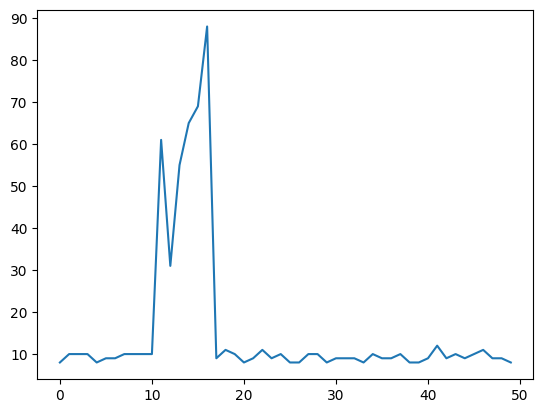

In [16]:
for repetition in range(training_config["num_repetitions"]):
    plt.plot(rewards_all_runs[repetition], label=f'Run {repetition + 1}')

max_length = min(len(run) for run in rewards_all_runs)
avg_rewards = np.mean([run[:max_length] for run in rewards_all_runs], axis=0)

plt.plot(avg_rewards, label='Average Reward', color='black', linestyle='--', linewidth=2)

plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode Across Multiple Runs with Averaging (No Smoothing and No Convolution)')
plt.legend(loc='upper left')
plt.show()
